In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import collections
import re
import string
from stop_words import get_stop_words

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize 
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import requests
from io import BytesIO

In [3]:
#import data and check if data were loaded correctly
df = pd.read_csv('/home/daria/Documents/vine/vivino.csv')
df.head()

,Brand,Description,Score
0,Baron G Rouge,Very dense body Powerful and very complex nose...,4
1,Baron G Rouge,Nice wine with autochthonous grapes from the h...,4
2,Baron G Rouge,A real discovery. Matches excellently with yel...,"4,5"
3,Baron G Rouge,Round freshness 100% rolle no passage in barrel,4
4,Baron G Rouge,"The years have passed by, but the wine is stil...",4


In [4]:
#Unique values for each Brand
collections.Counter(df.Brand)

Counter({'Baron G Rouge': 107,
         'Château de Bellet Rouge': 72,
         'Baron G Rose': 56,
         'Baron G Blanc': 70,
         'Château de Bellet Blanc': 47,
         'Agnes Rouge': 2,
         'Château de Bellet Rose': 7,
         'La Chapele Blanc': 5})

In [5]:
#Replace nice to good - because Nice is a city in France
df.Description = df['Description'].apply(lambda x:" ".join("good" if x == "nice" else x for x in x.split()))

In [6]:
#Remove intepunctions
remove_punct_map = dict.fromkeys(map(ord, string.punctuation))
df.Description = [s.translate(remove_punct_map) for s in df.Description]

In [7]:
#Remove stop words
nltk.download('stopwords')
stop = stopwords.words('english')
df['Description'] = df['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to /home/daria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#Remove digits
remove_digit_map = dict.fromkeys(map(ord, string.digits))
df.Description = [s.translate(remove_digit_map) for s in df.Description]

In [9]:
# Transform characters to lower case
df.Description = [s.lower() for s in df.Description] 

In [10]:
#Show results
df.Description.head()

0    very dense body powerful complex nose black ch...
1    nice wine autochthonous grapes heights nice fo...
2    a real discovery matches excellently yellow place
3                round freshness  rolle passage barrel
4                  the years passed wine still present
Name: Description, dtype: object

In [11]:
#Import nltk package
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /home/daria/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
lemmatizer = WordNetLemmatizer()
df['Description_tr'] = df['Description'].apply(lambda x: " ".join([
    lemmatizer.lemmatize(w)
    for w in x.split()]))

In [13]:
#Compare few records after lemmatization
df[['Description','Description_tr']].head()

,Description,Description_tr
0,very dense body powerful complex nose black ch...,very dense body powerful complex nose black ch...
1,nice wine autochthonous grapes heights nice fo...,nice wine autochthonous grape height nice foll...
2,a real discovery matches excellently yellow place,a real discovery match excellently yellow place
3,round freshness rolle passage barrel,round freshness rolle passage barrel
4,the years passed wine still present,the year passed wine still present


In [14]:
#Remove stop words
nltk.download('stopwords')
stop = stopwords.words('english')
df['Description_tr'] = df['Description_tr'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to /home/daria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
#Group all score reviews into negative and positive

In [16]:
df['score_bin'] = np.where(
((df.Score == '2,5') | (df.Score=='2') | (df.Score=='1,5') |(df.Score=='1') | (df.Score=='3')| (df.Score=='3,5')),
 'neg', 'pos')

In [17]:
df.score_bin.value_counts()

pos    285
neg     81
Name: score_bin, dtype: int64

In [18]:
#Bigram frequency for each score and brand
for i in range(0,5):
    for score in ['neg', 'pos']:
        wordcount_baron = {}
        for sent in df[(df.Brand == pd.DataFrame(df.Brand.value_counts()).index[i])&(df.score_bin==score)].Description_tr:
            token = nltk.word_tokenize(sent)
            bigram = list(ngrams(token, 2))
            for b in bigram:
                if b not in wordcount_baron:
                    wordcount_baron[b] = 1
                else:
                    wordcount_baron[b] += 1
            
        m = pd.DataFrame(collections.Counter(wordcount_baron).most_common(), columns = ['Word', 'Count'])
        m.to_csv('/home/daria/Documents/vine/counts/'+ str(pd.DataFrame(df.Brand.value_counts()).index[i])+
             str(score)+'_bigram_count.csv')
    #print(pd.DataFrame(df.Brand.value_counts()).index[i])
    #m.plot.bar(x='Word',y='Count')

In [19]:
#Bigram frequency for each brand
for i in range(0,5):
    wordcount_baron = {}
    for sent in df[df.Brand == pd.DataFrame(df.Brand.value_counts()).index[i]].Description_tr:
        token = nltk.word_tokenize(sent)
        bigram = list(ngrams(token, 2))
        for b in bigram:
            if b not in wordcount_baron:
                wordcount_baron[b] = 1
            else:
                wordcount_baron[b] += 1
    print(str(pd.DataFrame(df.Brand.value_counts()).index[i]))
    m = pd.DataFrame(collections.Counter(wordcount_baron).most_common(), columns = ['Word', 'Count'])
    m.to_csv('/home/daria/Documents/vine/counts/'+ str(pd.DataFrame(df.Brand.value_counts()).index[i])+
             '_word_count_vivino.csv')
    #print(pd.DataFrame(df.Brand.value_counts()).index[i])
    #m.plot.bar(x='Word',y='Count')

Baron G Rouge
Château de Bellet Rouge
Baron G Blanc
Baron G Rose
Château de Bellet Blanc


In [20]:
#Import mask for wordclou
url = "http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1530033379/wine_mask_xgk1tq.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [21]:
#Function for transforming colors
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [22]:
transformed_wine_mask = np.ndarray((np.array(img).shape[0], np.array(img).shape[1]), np.int32)

for i in range(len(np.array(img))):
    transformed_wine_mask[i] = list(map(transform_format, np.array(img)[i]))

In [23]:
def get_bigrams(sentence):
    tokens = nltk.word_tokenize(sentence)
    return zip(tokens, tokens[1:])

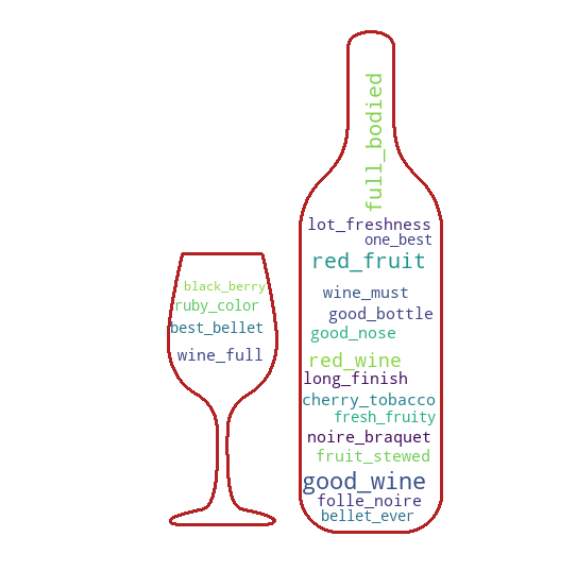

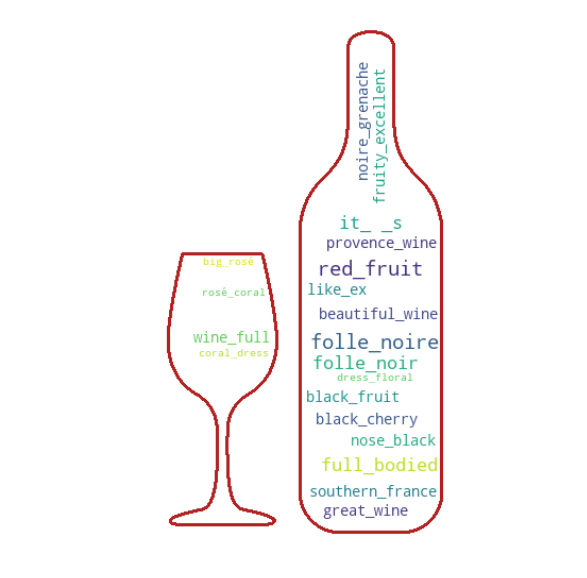

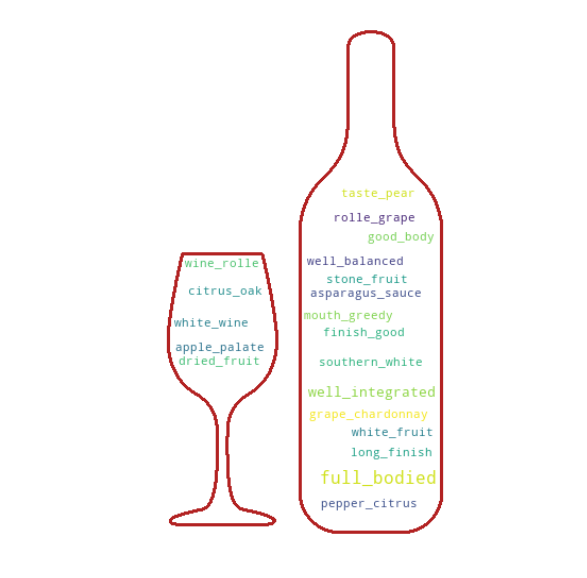

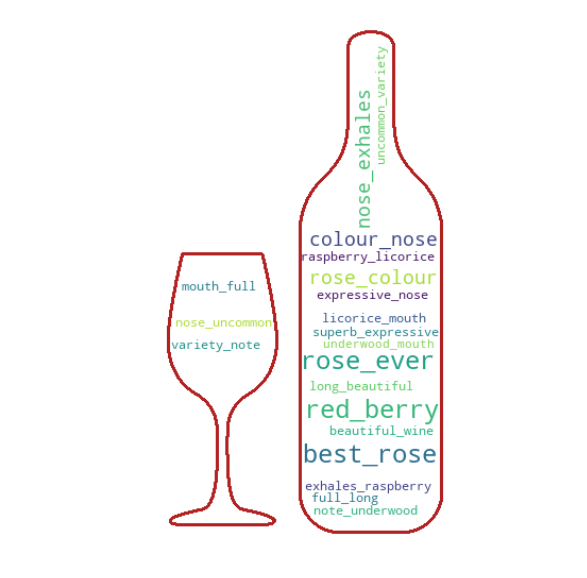

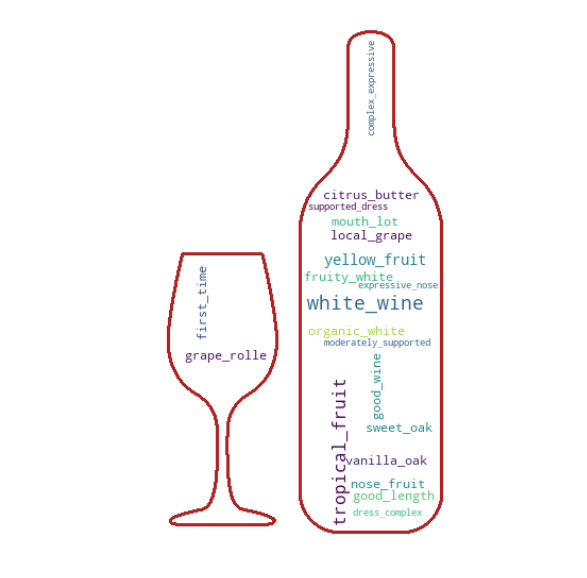

In [24]:
#Create Wordclouds for each brand 
wordcloud = WordCloud(background_color="white", max_words=20, mask=transformed_wine_mask,
                contour_width=3, contour_color='firebrick')

for i in range(0,5):
    bigrams_list = []
    for sent in df[df.Brand == pd.DataFrame(df.Brand.value_counts()).index[i]].Description_tr:
        bigrams = [' '.join(b) for b in get_bigrams(sent)]
        for bigram in bigrams:
            bigrams_list.append(bigram.replace(" ", "_"))
    text = " ".join(sent for sent in bigrams_list)
    wordcloud.generate(text)
            
    plt.figure(figsize=[20,10])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #plt.show()
    plt.savefig('/home/daria/Documents/vine/counts/bottle_wordcloud' + str(pd.DataFrame(df.Brand.value_counts()).index[i]) + 
                '.png')

In [25]:
#Create Wordclouds for each brand for negative and positive scores

In [26]:
df['score_bin'] = np.where(
((df.Score == '2,5') | (df.Score=='2') | (df.Score=='1,5') |(df.Score=='1') | (df.Score=='3')),
 'neg', 'pos')

In [27]:
df.score_bin.value_counts()

pos    322
neg     44
Name: score_bin, dtype: int64

neg
pos


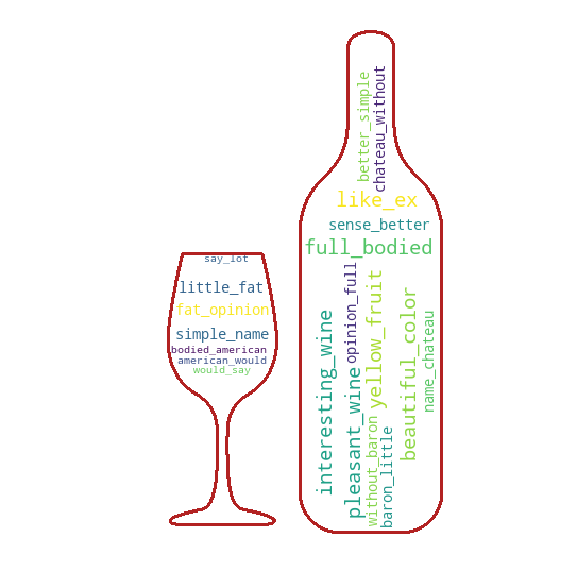

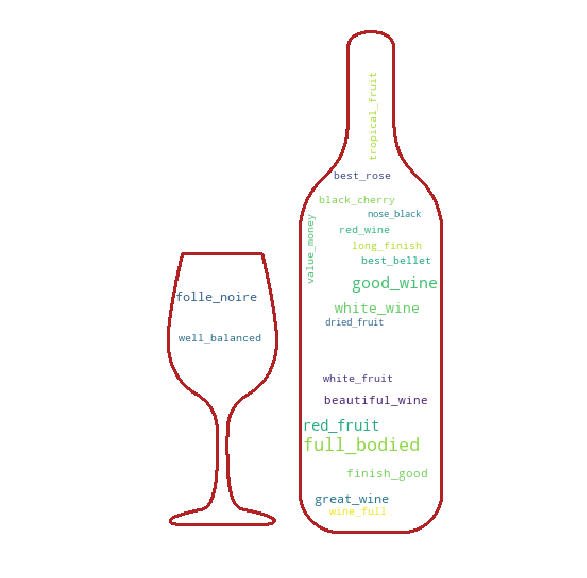

In [28]:
wordcloud = WordCloud(background_color="white", max_words=20, mask=transformed_wine_mask,
                contour_width=3, contour_color='firebrick')

for i in ['neg', 'pos']:
    print(i)
    bigrams_list = []
    for sent in df[df.score_bin == i].Description_tr:
        bigrams = [' '.join(b) for b in get_bigrams(sent)]
        for bigram in bigrams:
            bigrams_list.append(bigram.replace(" ", "_"))
    text = " ".join(sent for sent in bigrams_list)
    wordcloud.generate(text)
            
    plt.figure(figsize=[20,10])
    plt.imshow(wordcloud, 
               #interpolation='bilinear'
              )
    plt.axis("off")
    #plt.show()
    plt.savefig('/home/daria/Documents/vine/counts/bottle_wordcloud_' + i + 
                '.png')

In [29]:
#sentiment analysis

In [30]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

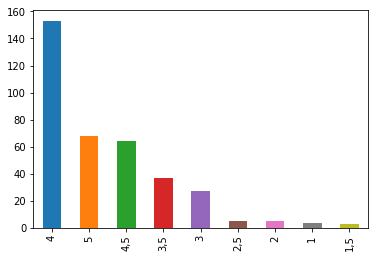

In [31]:
df['Score'].value_counts().plot(kind='bar')

In [32]:
#Define sentiment score
df['sentiment_scores_tb'] = [round(TextBlob(review).sentiment.polarity, 3) for review in df['Description_tr']]
df['sentiment_category_tb'] = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in df.sentiment_scores_tb]

In [33]:
df['score_bin'] = np.where(
((df.Score == '2,5') | (df.Score=='2') | (df.Score=='1,5') |(df.Score=='1') | (df.Score=='3,5')| (df.Score=='3')),
 'neg', 'pos')

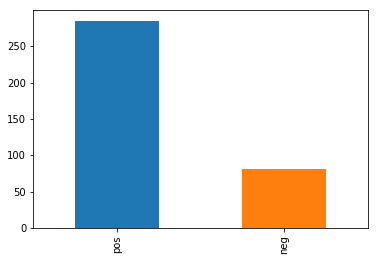

In [34]:
df.score_bin.value_counts().plot(kind = 'bar')

In [35]:
#Crosstab for real scores and scores from sentiment analysis
pd.crosstab(df.sentiment_category_tb, columns = df.Score)

Score,1,"1,5",2,"2,5",3,"3,5",4,"4,5",5
sentiment_category_tb,,,,,,,,,
negative,2,0,1,0,3,0,11,2,5
neutral,1,3,0,1,6,8,19,7,3
positive,1,0,4,4,18,29,123,55,60


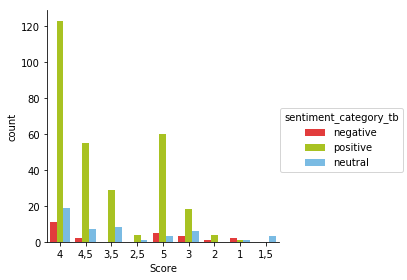

In [36]:
import seaborn as sns
sns.factorplot(x="Score", hue="sentiment_category_tb", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [37]:
df.sentiment_scores_tb.describe()

count    366.000000
mean       0.332899
std        0.299289
min       -0.650000
25%        0.100000
50%        0.332000
75%        0.515500
max        1.000000
Name: sentiment_scores_tb, dtype: float64

In [38]:
#Most negative and positive scores

In [39]:
cond = df[(df.Score == '2,5') | (df.Score=='2') | (df.Score=='1,5') |(df.Score=='1')& (df.sentiment_scores_tb < 0)]

In [40]:
pos_idx = df[(df.sentiment_scores_tb > 0.5)].index[0]
neg_idx = df[(df.sentiment_scores_tb < 0)].index[0]

In [41]:
print('Most Negative Words:', df.iloc[neg_idx][['Description_tr']][0])
print()
print('Most Positive Words:', df.iloc[pos_idx][['Description_tr']][0])

Most Negative Words: dense body powerful complex nose black cherry tobacco cocoa pepper fruit paste dried fruit palate fleshy tangy finish brings lot freshness alcohol ° feel whole balanced long finish acidulated black current

Most Positive Words: beautiful blackberry discovery rich velvety


In [42]:
pos_idx = df[(df.Score == '5') | (df.Score == '4,5') & (df.sentiment_scores_tb > 0.5)].index[0]
neg_idx = cond.index[0]

print('Most Negative Words:', df.iloc[neg_idx][['Description_tr']][0])
print()
print('Most Positive Words:', df.iloc[pos_idx][['Description_tr']][0])

Most Negative Words: sense better simple name chateau without baron little fat opinion full bodied american would say lot oak

Most Positive Words: powerful fruity uncommon top
